#  函数定义

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt # 是matplotlib的子包
import os
if os.name == 'posix': # 如果系统是mac或者linux
    plt.rcParams['font.sans-serif'] = ['Songti SC'] #中文字体为宋体
else:
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 在windows系统下显示微软雅黑
plt.rcParams['axes.unicode_minus'] = False # 负号用 ASCII 编码的-显示，而不是unicode的 U+2212
mpl.rc('xtick', labelsize=20)
mpl.rc('ytick', labelsize=20)
 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
import pickle  # 存各种神奇的数据结构
# import filter

In [2]:
from src.my_own_class import *

# 初步分析价格以及价格变化变量的统计特征，可视化

## 数据基本分析

In [3]:
# 读取原数据，fn是future index
fn1 = read_data(201405)
fn2 = read_data(201406)
print(len(fn1), len(fn2))
np.where(fn1.index.duplicated()) # 看看有没重复数据

600062 646375


(array([], dtype=int64),)

In [4]:
# # 保存价格数据，方便后续回测
# time_range1 = (fn1.index.time >= pd.to_datetime('09:30').time()) & (fn1.index.time <= pd.to_datetime('14:50').time())
# buy_range1 = (fn1['isBuy'] == 1)
# fn1Price = fn1.loc[(time_range1 & buy_range1),['Price']]
# fn1Price.to_csv('./dataset/201405_price.csv')

# time_range2 = (fn2.index.time >= pd.to_datetime('09:30').time()) & (fn2.index.time <= pd.to_datetime('14:50').time())
# buy_range2 = (fn2['isBuy'] == 1)
# fn2Price = fn2.loc[(time_range2 & buy_range2),['Price']]
# fn2Price.to_csv('./dataset/201406_price.csv')

# len(fn1Price), len(fn2Price)

In [5]:
# 保留时间，方便后续拼成等时间间隔的数据
Drop_call_auction1 = (fn1.index.time >= pd.to_datetime('09:30').time()) & (fn1.index.time <= pd.to_datetime('14:50').time())
fn1_time_lst = fn1.index[Drop_call_auction1]

Drop_call_auction2 = (fn2.index.time >= pd.to_datetime('09:30').time()) & (fn2.index.time <= pd.to_datetime('14:50').time())
fn2_time_lst = fn2.index[Drop_call_auction2]

In [6]:
# 跨天的数据deltaT改为nan
def DataProcess1(fn):
    _ = fn.copy()
    _ = _.loc[_['isBuy'] == 1,:] # 删去未交易数据
    _.loc[:,'Clock'] = _.index.time # 提取时间
    _ = _[(_['Clock'] > pd.to_datetime('09:30').time()) & (_['Clock'] < pd.to_datetime('14:50').time())] # 删去集合竞价数据
    _['DeltaPrice'] = _['Price'].diff() # 价格变化
    _['DeltaPrice'] = _['DeltaPrice'].round(2) # T期-T-1期
    _['DeltaTick'] = _['DeltaPrice']/0.2 # 最小变动单位是0.2，实际上差别很小
    # _ = _[_['DeltaPrice'] != 0] # 删去价格不变的数据 # 不删了
    _.loc[_['DeltaTick'] > 3,'DeltaTick'] = 3 # 统一一下范围
    _.loc[_['DeltaTick'] < -3,'DeltaTick'] = -3
    _['DeltaTick'] = _['DeltaTick'].round(2) 
    _['BidAskMid'] = (_['SP1'] + _['BP1'])/2
    _['BuySellIndicator'] = _.apply(lambda x: 1 if x['Price'] >= x['BidAskMid'] else -1 if x['Price'] <= x['BidAskMid'] else 0, axis=1) # 判断是以买一/卖一/中间价成交的
    _['VolLag1'] = _['TotalVol'].shift(1)
    _['VolLag2'] = _['TotalVol'].shift(2)
    _['VolLag3'] = _['TotalVol'].shift(3) # 这里会把上一天的数据shift过来，会在后面再考虑这一点的影响
    # _.dropna(inplace=True)
    _['BidAskSpread'] = _['SP1'] - _['BP1']
    _['DeltaTime'] = _.index.to_series().diff()/np.timedelta64(1,'s') # 交易之间相差的秒数
    _.loc[(_['DeltaTime'] > 12 * 60 * 60 * 2),'DeltaTime'] = np.nan # 隔日的数据deltaT改为nan
    # _.dropna(inplace=True)
    return _

fn1 = DataProcess1(fn1)
fn2 = DataProcess1(fn2)
len(fn1), len(fn2)

(251417, 270234)

In [7]:
# 划分状态，本来应该按Probit的MLE一起估计门限，但那样做效果并不好
from pandas.api.types import CategoricalDtype 
alpha = [-np.inf,-0.3, -0.1, 0.1, 0.3, np.inf] # 左闭右开

state_type = CategoricalDtype(range(len(alpha)-1), ordered=True)
deltaPstate1 = pd.cut(fn1['DeltaPrice'],alpha,labels = range(len(alpha)-1))
fn1["state"] = deltaPstate1.astype(state_type)

deltaPstate2 = pd.cut(fn2['DeltaPrice'],alpha,labels = range(len(alpha)-1))
fn2["state"] = deltaPstate2.astype(state_type)
def DataProcess2(fn):
    for date in range(len(set(fn['date']))):
        fn['StateLag1'] = fn['state'].shift(1)
        fn['StateLag2'] = fn['state'].shift(2)
        fn['StateLag3'] = fn['state'].shift(3)
        DropIndex = fn[fn['date'] == date].index[:3]
        fn.loc[DropIndex,'StateLag3'] = np.nan # 删去上一天shift过来的数据
    fn.dropna(inplace = True)
    fn['FutState1'] = fn['state'].shift(-1) # 改为对未来shift_period期预测
    fn['FutPrice1'] = fn['Price'].shift(-1) # 改为对未来shift_period期预测
    fn['FutState2'] = fn['state'].shift(-2) # 改为对未来shift_period期预测
    fn['FutPrice2'] = fn['Price'].shift(-2) # 改为对未来shift_period期预测
    return fn

fn1_shift = DataProcess2(fn1)
fn2_shift = DataProcess2(fn2)
print(len(fn1),len(fn2))
pd.concat([state_sum(fn1,fn2),state_sum(fn1_shift,fn2_shift)],axis=1)

251410 270226


,fn1状态计数,fn2状态计数,fn1状态计数,fn2状态计数
0,7144,5683,7144,5683
1,33669,33443,33669,33443
2,164543,187792,164543,187792
3,41683,40195,41683,40195
4,4371,3113,4371,3113


In [8]:
print('='*30)
print("Dummy Predict正确率")
dummy_predict_sttc(fn1_shift['DeltaPrice'],'fn1')
dummy_predict_sttc(fn2_shift['DeltaPrice'],'fn2')

Dummy Predict正确率
fn1上涨概率为0.1832
fn1不变概率为0.6545
fn1下跌概率为0.1623
fn2上涨概率为0.1603
fn2不变概率为0.6949
fn2下跌概率为0.1448


### 把fn1和fn2的shift1,2重新拼成等时间的数据

In [9]:
print(len(fn1_time_lst), len(fn2_time_lst))
fn1_shift = pd.DataFrame(index = fn1_time_lst).join(fn1_shift).fillna(method = 'ffill').dropna()
fn2_shift = pd.DataFrame(index = fn2_time_lst).join(fn2_shift).fillna(method = 'ffill').dropna()
print(np.where(fn1_shift.index.duplicated()))# 看看有没重复数据
print(fn1_shift.index.is_monotonic_increasing) # 看看index有没有乱序

512534 551268
(array([], dtype=int64),)
True


In [10]:
print('='*30)
print("Dummy Predict正确率")
dummy_predict_sttc(fn1_shift['DeltaPrice'],'fn1')
dummy_predict_sttc(fn2_shift['DeltaPrice'],'fn2')
pd.concat([state_sum(fn1,fn2),state_sum(fn1_shift,fn2_shift)],axis=1)

Dummy Predict正确率
fn1上涨概率为0.1845
fn1不变概率为0.6531
fn1下跌概率为0.1623
fn2上涨概率为0.1634
fn2不变概率为0.6918
fn2下跌概率为0.1448


,fn1状态计数,fn2状态计数,fn1状态计数,fn2状态计数
0,7144,5683,14757,11886
1,33669,33443,68428,67918
2,164543,187792,334757,381369
3,41683,40195,85518,83640
4,4371,3113,9069,6447


# 运用LASSO选取特征

有点懒了，写个垃圾桶类

In [11]:
from src.my_own_class import my_lasso_class

result for fn_lasso_shift1
训练集的特征大小为 (410024, 43)
训练集的标签大小为 (410024,)
验证集的特征大小为 (102506, 43)
验证集的标签大小为 (102506,)
测试集的特征大小为 (551260, 43)
测试集的标签大小为 (551260,)
best validation error: 0.03730 
corresponding test error:0.03430
best lambda: 0.00316
number of the features: 18
['Price' 'Volume' 'Amount' 'OpenInt' 'Open' 'Low' 'SV1' 'SV2' 'SV3' 'SV5'
 'BV1' 'BV4' 'BV5' 'BuySellIndicator' 'VolLag1' 'VolLag2' 'BidAskSpread'
 'StateLag1']


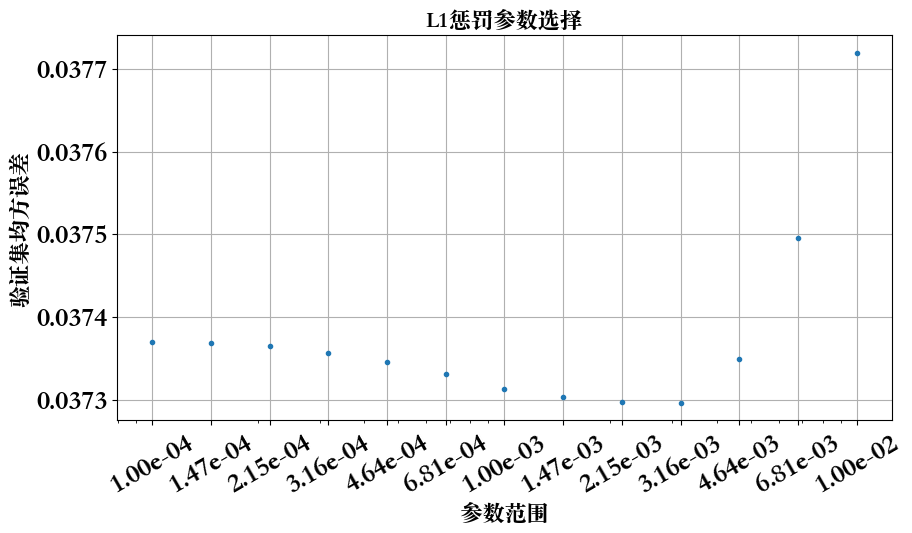

In [12]:
index_drop = ['date', 'Clock', 'sym', 'Time', 'FutPrice', 'FutState','Price2','Price3','FutState1','FutPrice1','FutState2','FutPrice2','LastClose']
all_features = [col for col in fn1_shift.columns if col not in index_drop] # 特征，需要drop一些列
label = 'FutPrice1'
lasso_shift1 = my_lasso_class(fn1_shift,fn2_shift,all_features,label,'fn_lasso_shift1')

result for fn_lasso_shift2
训练集的特征大小为 (410024, 43)
训练集的标签大小为 (410024,)
验证集的特征大小为 (102506, 43)
验证集的标签大小为 (102506,)
测试集的特征大小为 (551260, 43)
测试集的标签大小为 (551260,)
best validation error: 0.05858 
corresponding test error:0.05462
best lambda: 0.00215
number of the features: 24
['Price' 'Volume' 'Amount' 'OpenInt' 'TotalVol' 'TotalAmount' 'Open' 'Low'
 'SV1' 'SV2' 'SV3' 'SV5' 'BV1' 'BV4' 'BV5' 'DeltaTick' 'BuySellIndicator'
 'VolLag1' 'VolLag2' 'BidAskSpread' 'state' 'StateLag1' 'StateLag2'
 'StateLag3']


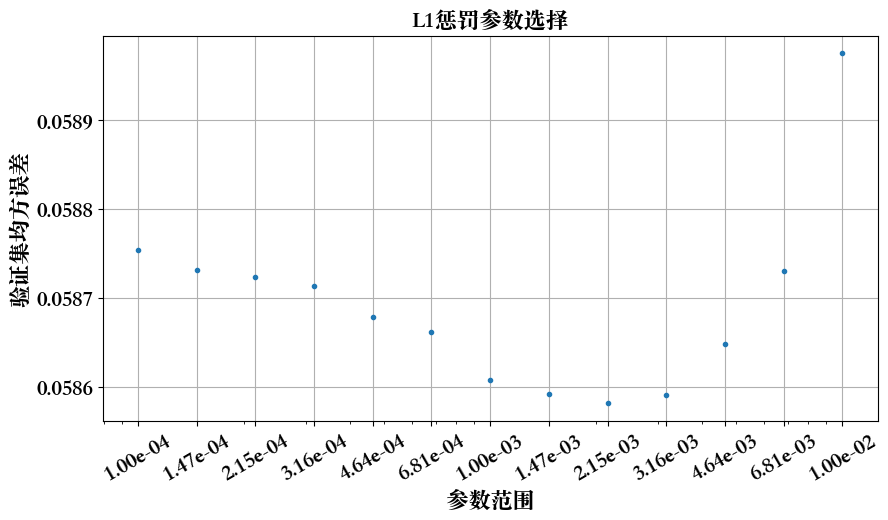

In [13]:
index_drop = ['date', 'Clock', 'sym', 'Time', 'FutPrice', 'FutState','Price2','Price3','FutState1','FutPrice1','FutState2','FutPrice2','LastClose']
all_features = [col for col in fn1_shift.columns if col not in index_drop] # 特征，需要drop一些列
label = 'FutPrice2'
lasso_shift2 = my_lasso_class(fn1_shift,fn2_shift,all_features,label,'fn_lasso_shift2')

# Probit模型

In [14]:
index_drop = ['Open','VolLag1']
all_features = [col for col in lasso_shift1.X_list if col not in index_drop]
label = 'FutState1'
probit_shift1 = my_probit_class(fn1_shift,fn2_shift,all_features,label,'fn_shift1')

result for fn_shift1
训练集的特征大小为 (512529, 16)
训练集的标签大小为 (512529,)
测试集的特征大小为 (551260, 16)
测试集的标签大小为 (551260,)
Optimization terminated successfully.
         Current function value: 1.112906
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41


In [15]:
probit_shift1.mod_prob.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:              FutState1   Log-Likelihood:            -5.7040e+05
Model:                   OrderedModel   AIC:                         1.141e+06
Method:            Maximum Likelihood   BIC:                         1.141e+06
Date:                Wed, 12 Apr 2023                                         
Time:                        22:28:00                                         
No. Observations:              512529                                         
Df Residuals:                  512509                                         
Df Model:                          20                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Price               -0.0629      0.004    -14.917      0.000      -0.071      -0.055
Volume               0.3353      0.159      2.115      0.034       0.025       0.646
Amount              -0.3670      0.158     -2.315      0.021      -0.678      -0.056
OpenInt             -0.0318      0.002    -14.710      0.000      -0.036      -0.028
Low                  0.0567      0.004     13.091      0.000       0.048       0.065
SV1                 -0.1616      0.002    -96.898      0.000      -0.165      -0.158
SV2                  0.0291      0.002     16.243      0.000       0.026       0.033
SV3                  0.0122      0.002      6.795      0.000       0.009       0.016
SV5                  0.0089      0.002      5.308      0.000       0.006       0.012
BV1                  0.1337      0.002     83.920      0.000       0.131       0.137
BV4                  0.0111      0.002      6.342      0.000       0.008       0.015
BV5                  0.0148      0.002      8.449      0.000       0.011       0.018
BuySellIndicator    -0.3180      0.002   -196.388      0.000      -0.321      -0.315
VolLag2              0.0171      0.002      8.504      0.000       0.013       0.021
BidAskSpread        -0.0969      0.002    -62.038      0.000      -0.100      -0.094
StateLag1            0.0462      0.002     29.926      0.000       0.043       0.049
0/1                 -1.6880      0.003   -566.925      0.000      -1.694      -1.682
1/2                 -0.0426      0.003    -14.509      0.000      -0.048      -0.037
2/3                  0.5181      0.002    340.573      0.000       0.515       0.521
3/4                  0.3024      0.003     88.292      0.000       0.296       0.309
====================================================================================
"""

In [16]:
probit_shift1.train_predict_sttc()

最大状态数为 5.0
训练集内状态预测正确率为 0.5715
训练集内涨跌方向预测正确率为 0.5739
训练集内买卖方向预测正确率为 0.9291
模型每日去重开仓信号次数 0.9000
最大状态数为 5.0
测试集内状态预测正确率为 0.6097
测试集内涨跌方向预测正确率为 0.6116
测试集内买卖方向预测正确率为 0.9462
模型每日去重开仓信号次数 0.6667


In [17]:
probit_shift1.state_sum_df

,fn1真实状态计数,fn1预测状态计数,fn2真实状态计数,fn2预测状态计数
0,27940,449,22889,633
1,98690,1139,100988,1550
2,290651,501830,334663,541865
3,87034,9109,86466,7203
4,8214,2,6254,9


In [18]:
probit_shift1.probit_t_values

,index,0
12,BuySellIndicator,196.388274
5,SV1,96.897523
9,BV1,83.919585
14,BidAskSpread,62.038341
15,StateLag1,29.926326
6,SV2,16.242943
0,Price,14.917451
3,OpenInt,14.709852
4,Low,13.090642
13,VolLag2,8.503950


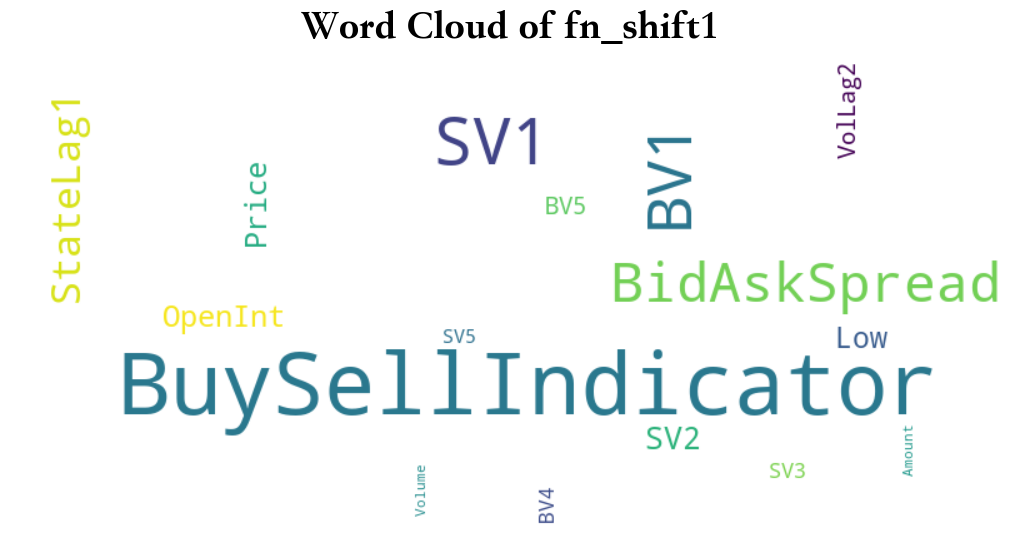

In [19]:
probit_shift1.probit_word_plot()

In [20]:
index_drop = ['VolLag1','Price','TotalAmount','BV5']
all_features = [col for col in lasso_shift2.X_list if col not in index_drop]
label = 'FutState2'
probit_shift2 = my_probit_class(fn1_shift,fn2_shift,all_features,label,'fn_shift2')

result for fn_shift2
训练集的特征大小为 (512529, 20)
训练集的标签大小为 (512529,)
测试集的特征大小为 (551260, 20)
测试集的标签大小为 (551260,)
Optimization terminated successfully.
         Current function value: 1.039948
         Iterations: 60
         Function evaluations: 61
         Gradient evaluations: 61


In [21]:
probit_shift2.mod_prob.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:              FutState2   Log-Likelihood:            -5.3300e+05
Model:                   OrderedModel   AIC:                         1.066e+06
Method:            Maximum Likelihood   BIC:                         1.066e+06
Date:                Wed, 12 Apr 2023                                         
Time:                        22:30:34                                         
No. Observations:              512529                                         
Df Residuals:                  512505                                         
Df Model:                          24                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Volume               0.4676      0.153      3.049      0.002       0.167       0.768
Amount              -0.4256      0.153     -2.777      0.005      -0.726      -0.125
OpenInt             -0.0064      0.002     -2.974      0.003      -0.011      -0.002
TotalVol            -0.1180      0.049     -2.402      0.016      -0.214      -0.022
Open                 0.0146      0.004      3.497      0.000       0.006       0.023
Low                 -0.0154      0.005     -3.346      0.001      -0.024      -0.006
SV1                 -0.0204      0.002    -11.977      0.000      -0.024      -0.017
SV2                 -0.0118      0.002     -6.422      0.000      -0.015      -0.008
SV3                 -0.0095      0.002     -5.214      0.000      -0.013      -0.006
SV5                 -0.0094      0.002     -5.513      0.000      -0.013      -0.006
BV1                  0.0057      0.002      3.438      0.001       0.002       0.009
BV4                  0.0044      0.002      2.649      0.008       0.001       0.008
DeltaTick           -0.2552      0.011    -22.337      0.000      -0.278      -0.233
BuySellIndicator    -0.0186      0.002    -11.605      0.000      -0.022      -0.015
VolLag2              0.1159      0.049      2.360      0.018       0.020       0.212
BidAskSpread        -0.0145      0.002     -9.102      0.000      -0.018      -0.011
state                0.2801      0.011     24.386      0.000       0.258       0.303
StateLag1            0.0134      0.002      8.512      0.000       0.010       0.017
StateLag2            0.0072      0.002      4.583      0.000       0.004       0.010
StateLag3            0.0075      0.002      4.826      0.000       0.004       0.011
0/1                 -1.8865      0.004   -536.695      0.000      -1.893      -1.880
1/2                 -0.0817      0.004    -22.716      0.000      -0.089      -0.075
2/3                  0.6053      0.001    432.807      0.000       0.603       0.608
3/4                  0.2153      0.003     64.169      0.000       0.209       0.222
====================================================================================
"""

In [22]:
probit_shift2.train_predict_sttc()

最大状态数为 5.0
训练集内状态预测正确率为 0.6386
训练集内涨跌方向预测正确率为 0.6386
训练集内买卖方向预测正确率为 0.9524
模型每日去重开仓信号次数 0.0000
最大状态数为 5.0
测试集内状态预测正确率为 0.6775
测试集内涨跌方向预测正确率为 0.6775
测试集内买卖方向预测正确率为 0.9661
模型每日去重开仓信号次数 0.0000


In [23]:
probit_shift2.state_sum_df

,fn1真实状态计数,fn1预测状态计数,fn2真实状态计数,fn2预测状态计数
0,15101,NaN,12072,NaN
1,70964,NaN,70856,NaN
2,327324,512508.0,373500,551251.0
3,89826,19.0,88223,9.0
4,9314,2.0,6609,NaN


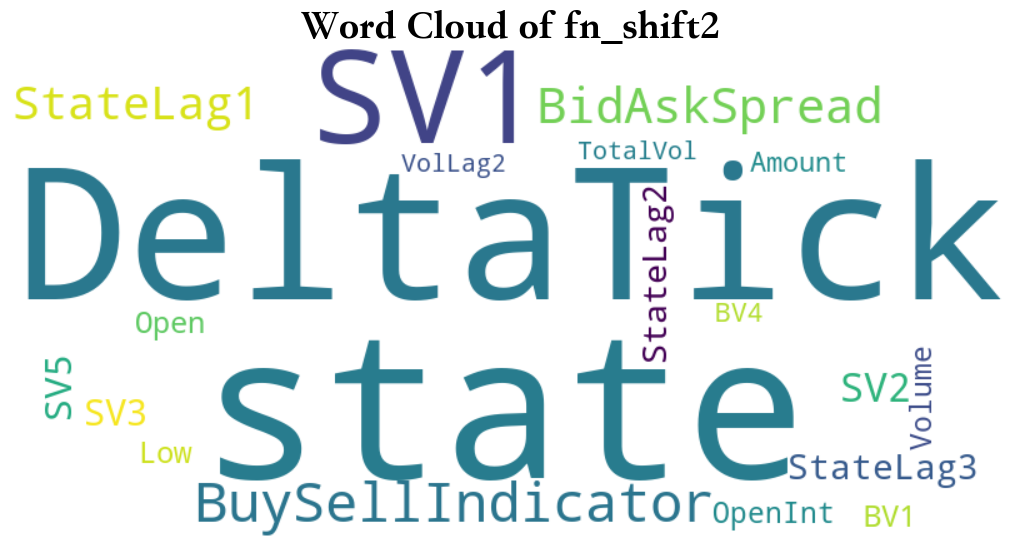

In [24]:
probit_shift2.probit_word_plot()

## 3. 试试AdaBoost

In [25]:
index_drop = []
all_features = [col for col in lasso_shift1.X_list if col not in index_drop]
label = 'FutState1'
adaboost_shift1 = my_adaboost_class(fn1_shift,fn2_shift,all_features,label,'fn_shift1')

result for fn_shift1
训练集的特征大小为 (512529, 18)
训练集的标签大小为 (512529,)
测试集的特征大小为 (551260, 18)
测试集的标签大小为 (551260,)


In [26]:
adaboost_shift1.train_predict_sttc()

最大状态数为 5.0
训练集内状态预测正确率为 0.5788
训练集内涨跌方向预测正确率为 0.5963
训练集内买卖方向预测正确率为 0.9176
模型每日去重开仓信号次数 58.1000
最大状态数为 5.0
测试集内状态预测正确率为 0.6015
测试集内涨跌方向预测正确率为 0.6169
测试集内买卖方向预测正确率为 0.9224
模型每日去重开仓信号次数 31.0476


In [27]:
adaboost_shift1.state_sum_df

,fn1真实状态计数,fn1预测状态计数,fn2真实状态计数,fn2预测状态计数
0,27940,11202,22889,9565
1,98690,11726,100988,10407
2,290651,447468,334663,484328
3,87034,36278,86466,35847
4,8214,5855,6254,11113


In [28]:
pred_state_sum(adaboost_shift1.train_df,adaboost_shift1.test_df).to_clipboard()
pred_state_sum(adaboost_shift1.train_df,adaboost_shift1.test_df)

,fn1真实状态计数,fn1预测状态计数,fn2真实状态计数,fn2预测状态计数
0,27940,11202,22889,9565
1,98690,11726,100988,10407
2,290651,447468,334663,484328
3,87034,36278,86466,35847
4,8214,5855,6254,11113


In [29]:
adaboost_shift1.adaboost_feature_compare

,3,2,7,12,8,9,10,11,14,6,0,15,13,5,17,16,1,4
变量名,OpenInt,Amount,SV2,BV5,SV3,SV5,BV1,BV4,VolLag1,SV1,Price,VolLag2,BuySellIndicator,Low,StateLag1,BidAskSpread,Volume,Open
权重,0.108638,0.106534,0.088721,0.084972,0.083515,0.07897,0.078697,0.063002,0.05581,0.054289,0.049211,0.048912,0.034768,0.024016,0.015416,0.012769,0.007715,0.004044


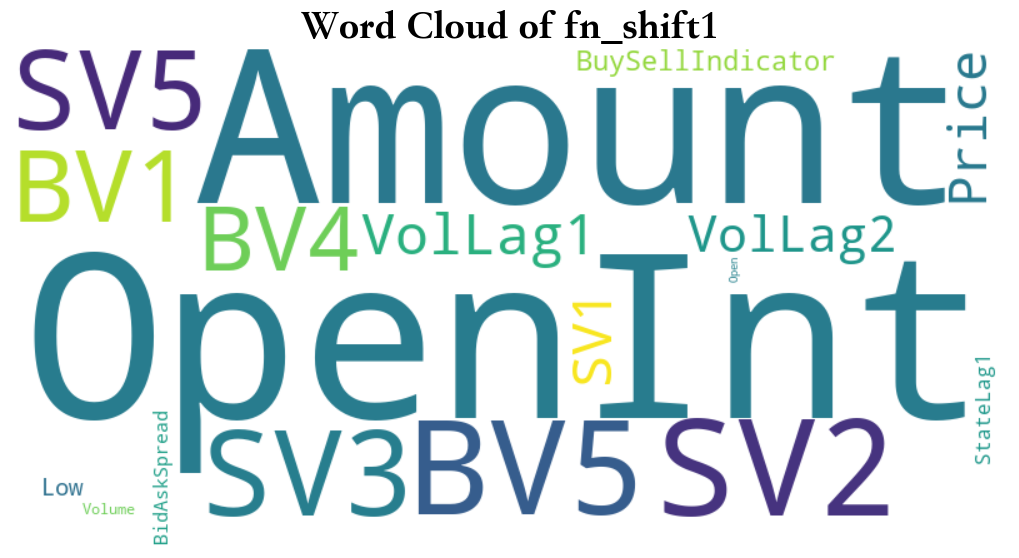

In [30]:
adaboost_shift1.adaboost_word_plot()

In [31]:
index_drop = []
all_features = [col for col in lasso_shift2.X_list if col not in index_drop]
label = 'FutState2'
adaboost_shift2 = my_adaboost_class(fn1_shift,fn2_shift,all_features,label,'fn_shift2')

result for fn_shift2
训练集的特征大小为 (512529, 24)
训练集的标签大小为 (512529,)
测试集的特征大小为 (551260, 24)
测试集的标签大小为 (551260,)


In [55]:
adaboost_shift2.train_predict_sttc()

最大状态数为 5.0
训练集内状态预测正确率为 0.6385
训练集内涨跌方向预测正确率为 0.6415
训练集内买卖方向预测正确率为 0.9483
模型每日去重开仓信号次数 17.4000
最大状态数为 5.0
测试集内状态预测正确率为 0.6454
测试集内涨跌方向预测正确率为 0.6523
测试集内买卖方向预测正确率为 0.9300
模型每日去重开仓信号次数 7.1429


In [33]:
adaboost_shift2.state_sum_df

,fn1真实状态计数,fn1预测状态计数,fn2真实状态计数,fn2预测状态计数
0,15101,1225,12072,16154
1,70964,216,70856,7524
2,327324,503722,373500,518663
3,89826,3310,88223,3159
4,9314,4056,6609,5760


In [34]:
pred_state_sum(adaboost_shift2.train_df,adaboost_shift2.test_df).to_clipboard()
pred_state_sum(adaboost_shift2.train_df,adaboost_shift2.test_df)

,fn1真实状态计数,fn1预测状态计数,fn2真实状态计数,fn2预测状态计数
0,15101,1225,12072,16154
1,70964,216,70856,7524
2,327324,503722,373500,518663
3,89826,3310,88223,3159
4,9314,4056,6609,5760


In [35]:
adaboost_shift2.adaboost_feature_compare

,2,10,3,12,9,14,11,13,0,8,18,5,4,7,1,22,17,15,21,6,20,23,19,16
变量名,Amount,SV3,OpenInt,BV1,SV2,BV5,SV5,BV4,Price,SV1,VolLag2,TotalAmount,TotalVol,Low,Volume,StateLag2,VolLag1,DeltaTick,StateLag1,Open,state,StateLag3,BidAskSpread,BuySellIndicator
权重,0.108651,0.099543,0.088188,0.084818,0.081401,0.072725,0.070162,0.065423,0.04818,0.040185,0.037406,0.034669,0.029061,0.02746,0.015407,0.015142,0.013467,0.012904,0.012765,0.012328,0.0123,0.008974,0.005333,0.003507


In [36]:
adaboost_shift2.adaboost_word_plot

<bound method my_adaboost_class.adaboost_word_plot of <src.my_own_class.my_adaboost_class object at 0x7f8074fa35b0>>

## 模型转信号

In [37]:
fn1Price = pd.read_csv('./dataset/201405_price.csv',index_col = 0)
fn2Price = pd.read_csv('./dataset/201406_price.csv',index_col = 0)
fn1Price.index = pd.to_datetime(fn1Price.index)
fn2Price.index = pd.to_datetime(fn2Price.index)

In [38]:
# 预测状态转仓位
def State2Pos(y_df,df_name):
    state_num = y_df.max().max()
    _ = pd.DataFrame(np.where(y_df > state_num/2+1, 1, np.where(y_df < state_num/2-1, -1, 0)), index=y_df.index, columns=y_df.columns)
    # _ = pd.DataFrame(np.where(y_df > state_num/2, 1, np.where(y_df < state_num/2, -1, 0)), index=y_df.index, columns=y_df.columns)
    _ = _[_ != 0].dropna()
    
    try:
        _ = _.groupby(_.index.date).apply(lambda x: x[x['FutPredict'] != x['FutPredict'].shift(1)]).reset_index().set_index('Time').drop(columns='level_0')
        _.index.name = None
        _ = fn2Price.join(_,how='left').fillna(method = 'ffill').fillna(0)
        _ = _[~_.index.duplicated(keep='first')]
        _ = _.dropna()
        # _.to_csv(f'./result/{df_name}.csv')
    except KeyError:
        _ = np.nan
    return _

In [39]:
Pos_save = {}
lst1 = [probit_shift1,probit_shift2,adaboost_shift1,adaboost_shift2]
lst2 = ['probit_shift1','probit_shift2','adaboost_shift1','adaboost_shift2']
for i,j,k in zip(lst1,lst2,[0,1,0,1]):
    Pos_save[j] = State2Pos(i.test_df.shift(k),j)

In [40]:
for j in lst2: # 看看有没重复的
    try:
        print(j,np.where(Pos_save[j].index.duplicated()))
    except AttributeError:
        pass

probit_shift1 (array([], dtype=int64),)
adaboost_shift1 (array([], dtype=int64),)
adaboost_shift2 (array([], dtype=int64),)


In [41]:
_ = pickle_save(Pos_save,'_pos_no_filter')

<class 'dict'>


# 回测

In [47]:
from src.backtest import Displayer, BackTester
import talib

class SymbolicTestor(BackTester):
    def init(self):
        self.params = {'factor': pd.Series}
        
    @BackTester.process_strategy
    def run_(self, *args, **kwargs) -> dict[str: int]:
        factor = np.array(self.params['factor'])
        long_cond = factor > 0
        short_cond = factor < 0
        self.backtest_env['signal'] = np.where(long_cond, 1, np.nan)
        self.backtest_env['signal'] = np.where(short_cond, -1, self.backtest_env['signal'])
        self.construct_position_(keep_raw=True, max_holding_period=1200, take_profit=None, stop_loss=None)
        

In [48]:

def my_friend_backtest(i,data,comm):
    print('='*30)
    print(f"result for {i} with commission {comm}")
    symbol_data = pd.DataFrame(index = data[i].index)
    symbol_data['Open'] = data[i]['Price']
    symbol_data['High'] = data[i]['Price']
    symbol_data['Low'] = data[i]['Price']
    symbol_data['Close'] = data[i]['Price']
    symbol_data['Volume'] = 0
    factor = data[i]['FutPredict']
    
    bt = SymbolicTestor(symbol_data, transact_base='PreClose',commissions=(comm,comm))
    bt.run_(factor=factor.values)
    md = bt.summary()
    print(md.out_stats)
    fig, ax, *_ = md.plot_()
    fig.savefig(f'./result/no_filter_{i}_comm_{comm}.png')
    fig.show()
    print('='*30)
    bt.fees_factor


In [49]:
import pickle

In [50]:
# comm_fut = 0.000023
with open('model_pos_no_filter.pickle', 'rb') as f:
    data = pickle.load(f)
comm_fut = 0.0001265

result for probit_shift1 with commission 0.0001265
Annualized_Mean                0.043736
Annualized_Std                 0.125455
Sharpe                         0.348622
Excess_Annualized_Mean         0.053939
Excess_Annualized_Std          0.250972
Excess_sharpe                  0.214920
MaxDrawDown                    0.039727
LongCounts                     0.000000
MeanLongTime                   0.000000
PerLongReturn                  0.000000
ShortCounts                    1.000000
MeanShortTime             269543.000000
PerShortReturn                 0.003584
PnL                                 NaN
WinRate                        1.000000
dtype: float64


/var/folders/dc/5hscf4cj45767ypphg15zwd80000gn/T/ipykernel_41701/2196533551.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


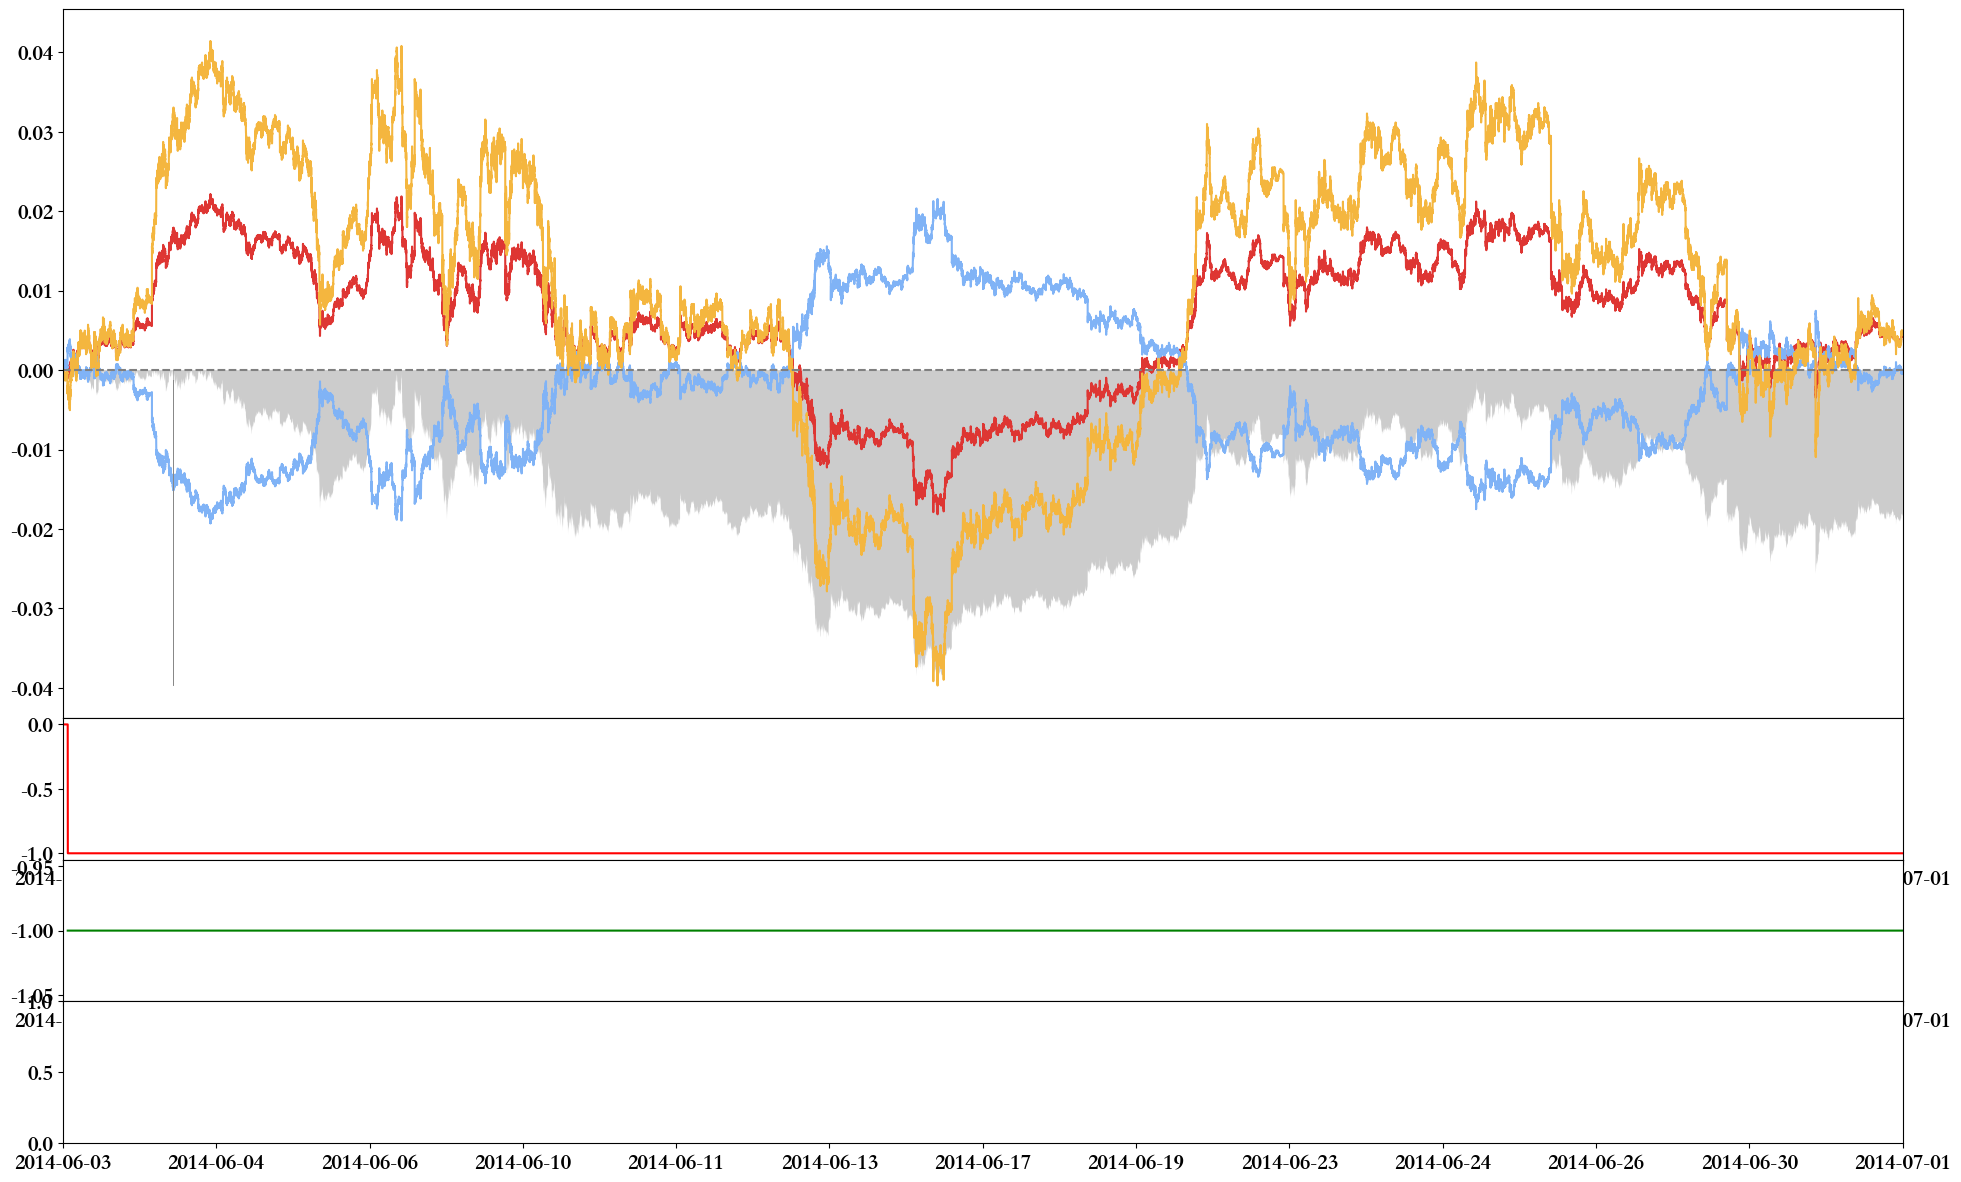

In [51]:
my_friend_backtest(lst2[0],data,comm = comm_fut)

In [52]:
my_friend_backtest(lst2[1],data,comm = comm_fut)

result for probit_shift2 with commission 0.0001265


AttributeError: 'float' object has no attribute 'index'

result for adaboost_shift1 with commission 0.0001265
Annualized_Mean             0.739667
Annualized_Std              0.127022
Sharpe                      5.823122
Excess_Annualized_Mean      0.749869
Excess_Annualized_Std       0.202996
Excess_sharpe               3.694015
MaxDrawDown                 0.022727
LongCounts                319.000000
MeanLongTime              292.896552
PerLongReturn               0.000042
ShortCounts               320.000000
MeanShortTime             550.437500
PerShortReturn              0.000148
PnL                         1.355280
WinRate                     0.480438
dtype: float64


/var/folders/dc/5hscf4cj45767ypphg15zwd80000gn/T/ipykernel_41701/2196533551.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


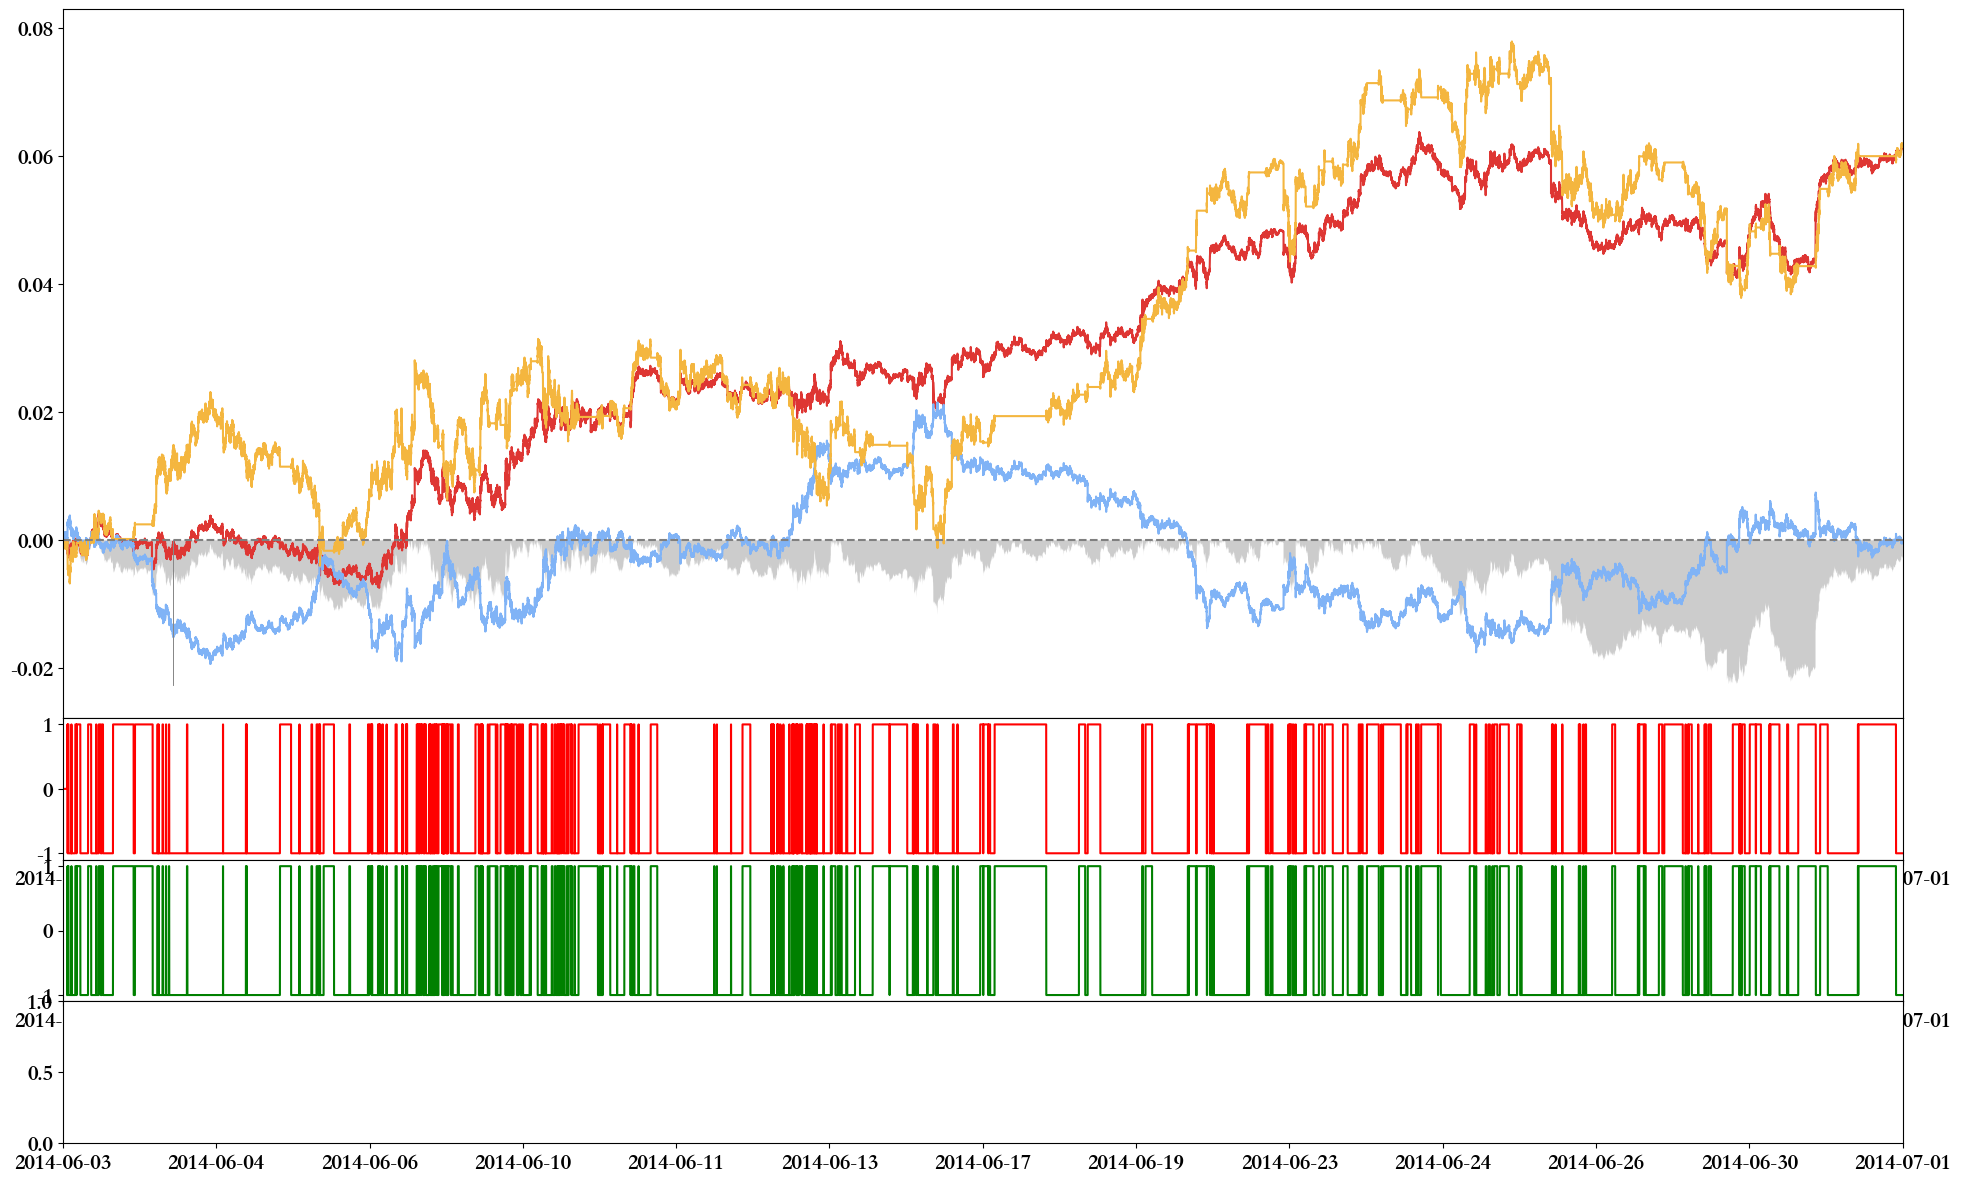

In [53]:
my_friend_backtest(lst2[2],data,comm = comm_fut)

result for adaboost_shift2 with commission 0.0001265
Annualized_Mean              0.119989
Annualized_Std               0.125634
Sharpe                       0.955066
Excess_Annualized_Mean       0.130191
Excess_Annualized_Std        0.185302
Excess_sharpe                0.702589
MaxDrawDown                  0.037982
LongCounts                  24.000000
MeanLongTime              5347.333333
PerLongReturn               -0.000084
ShortCounts                 24.000000
MeanShortTime             5884.583333
PerShortReturn               0.000493
PnL                          1.147059
WinRate                      0.500000
dtype: float64


/var/folders/dc/5hscf4cj45767ypphg15zwd80000gn/T/ipykernel_41701/2196533551.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


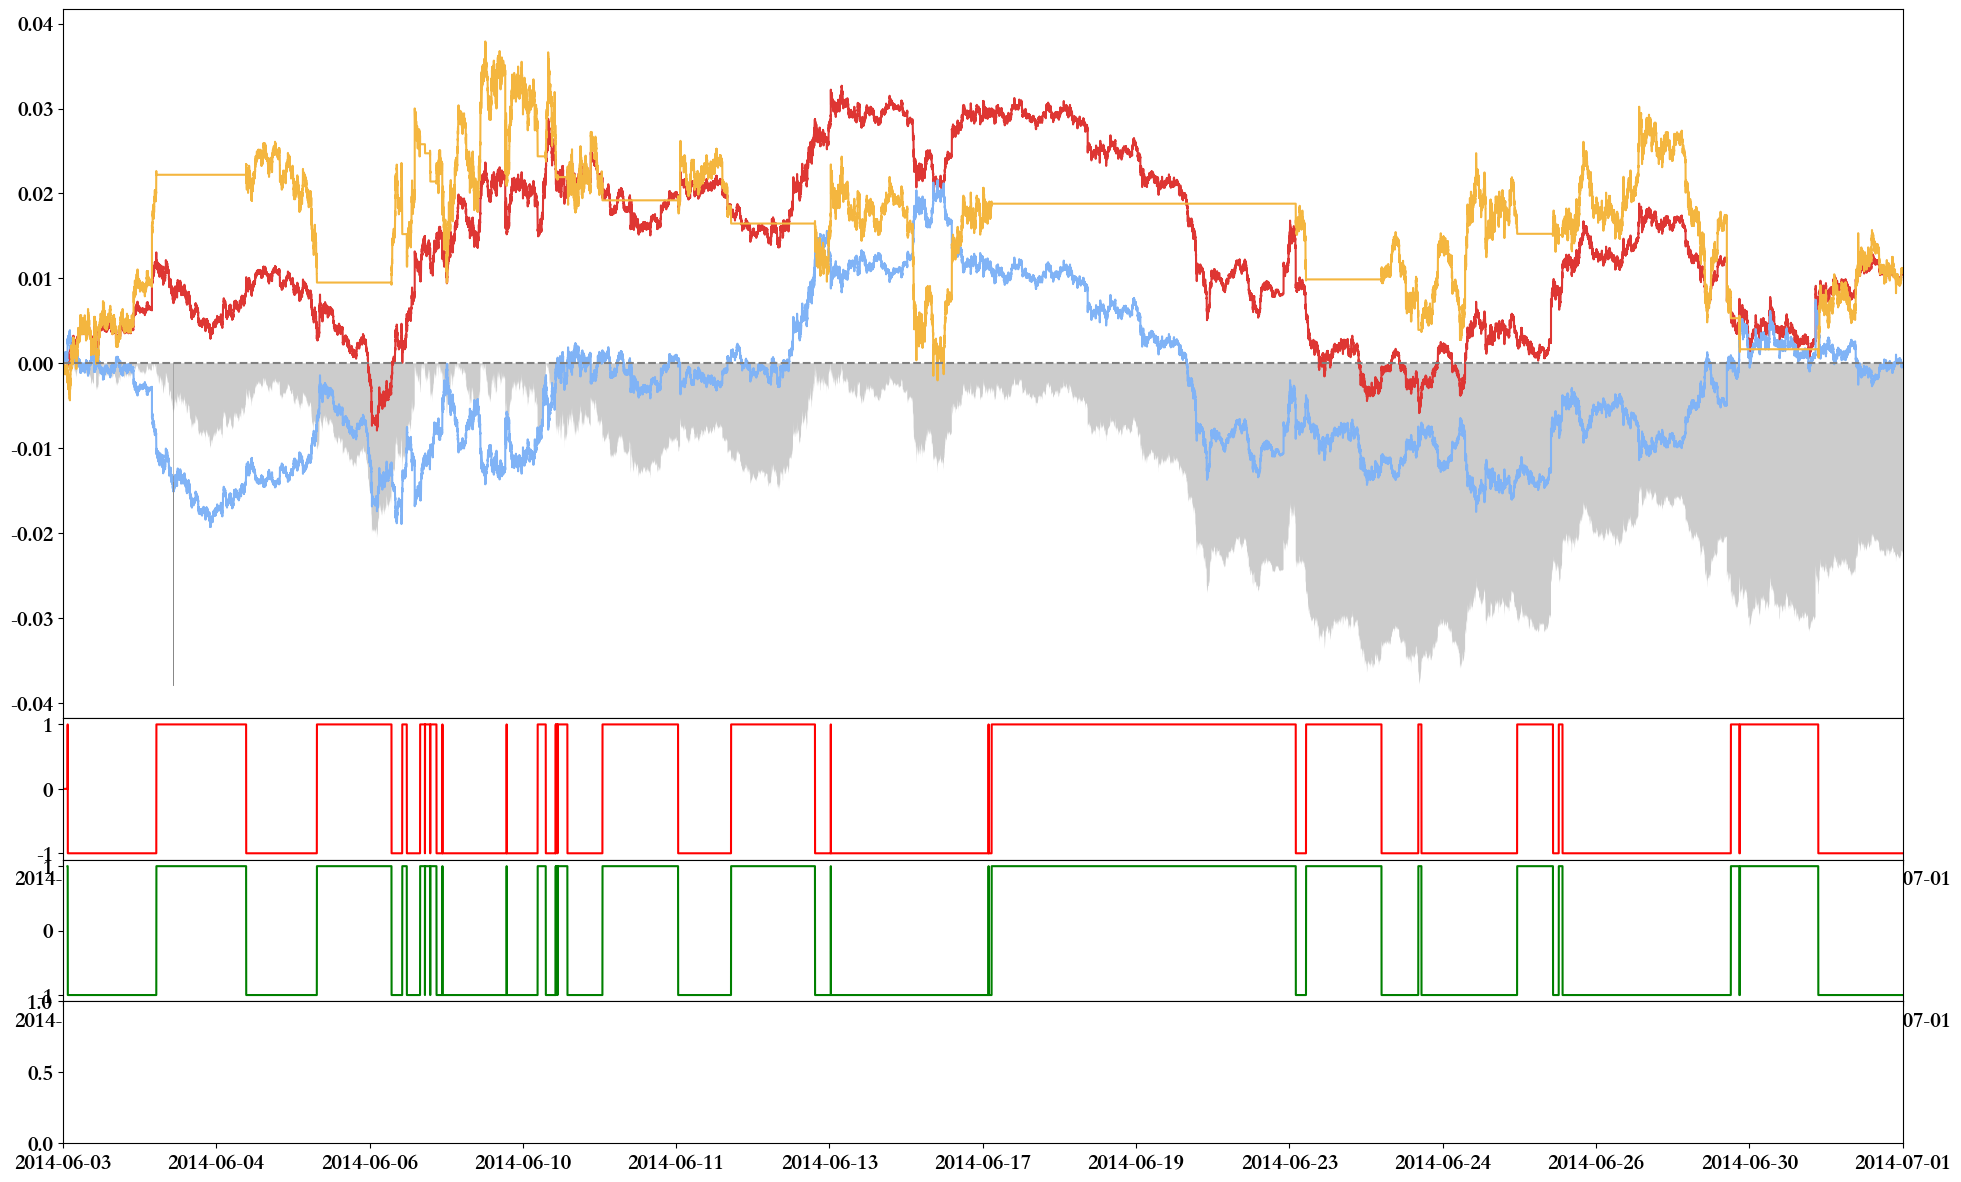

In [54]:
my_friend_backtest(lst2[3],data,comm = comm_fut)